In [1]:
from keras.models import Model, load_model
from keras.layers import Input, Conv2D
from ae_model import encoder_vgg16, decoder1_vgg16, decoder2_vgg16, decoder3_vgg16, encoder1_vgg16
import numpy as np
import tensorflow as tf

ins = Input(shape=(224, 224, 3))

## Save the decoder pretrained weights

In [ ]:
ae_model = load_model('./grid-search/checkpoints/emps_models/', compile=False)
ae_model.summary()

In [3]:
ins = Input(shape=(224, 224, 3))
encoder_model = Model(ins, encoder_vgg16(ins))
print(len(encoder_model.layers))
##34

34


In [ ]:
for l1, l2 in zip(encoder_model.layers[:34], ae_model.layers[0:34]):
    l1.set_weights(l2.get_weights())

ae_weight = ae_model.get_weights()[0][1]
encoder_weight = encoder_model.get_weights()[0][1]

In [ ]:
np.save('./grid-search/checkpoints/emps_models_encoder_weights_0_1.npy', encoder_weight) # for comparison
encoder_model.save('./grid-search/checkpoints/emps_models_encoder_weights.h5') # for encoder-decoder test

In [ ]:
encoder_vgg16_model = tf.keras.models.Sequential(encoder_model.layers[:-2])
encoder_vgg16_model.summary()

In [ ]:
test_weight = encoder_vgg16_model.get_weights()[0][1]

In [ ]:
encoder_vgg16_model.save('./grid-search/checkpoints/emps_models_encoder_vgg16_weights.h5')

### Build vgg16 and load saved weights

In [2]:
load_weight_model = Model(ins, encoder_vgg16(ins))

In [3]:
conn_model = tf.keras.models.Sequential(load_weight_model.layers[:-2])

In [6]:
conn_model.load_weights('./grid-search/checkpoints/emps_models_encoder_vgg16_weights.h5')

In [7]:
conn_model_weight = conn_model.get_weights()[0][1]
compare_weight = np.load('./grid-search/checkpoints/emps_models_encoder_weights_0_1.npy')

if conn_model_weight.all() == compare_weight.all():
    print("Both weights are identical")
else: 
    print("Something wrong, weghts are different")

Both weights are identical


### Problem  
ValueError: `logits` and `labels` must have the same shape, received ((None, 1) vs (None, 224, 224, 1)).    
The most primitive model of VGG16 cannot be used in this way, my data is not of this structure.    
The structure of the Dense layer is different.... So basically it can't be trained like this.    

### New idea  @10.21

Modify the shape of the data through resahpe

In [4]:
from keras.layers import Flatten, Dense, Reshape

conn_model.add(Flatten())
conn_model.add(Dense(4096, activation='relu'))
conn_model.add(Dense(4096, activation='relu'))
conn_model.add(Dense(224*224, activation='sigmoid'))
conn_model.add(Reshape((224, 224, 1)))
conn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

In [5]:
import segmentation_models as sm
from keras.callbacks import TensorBoard
from datetime import datetime

logssss = './grid-search/logs/segmentation_test/vgg16_' + datetime.now().strftime("%Y%m%d-%H%M%S") 
conn_model.compile(optimizer='Adam', loss=sm.losses.binary_focal_jaccard_loss, metrics=[sm.metrics.iou_score])


Segmentation Models: using `keras` framework.


In [6]:
x_train = np.load('./grid-search/dataset-emps/npy/spilt_80train_20test/x_train.npy')
y_train = np.load('./grid-search/dataset-emps/npy/spilt_80train_20test/y_train.npy')
x_test = np.load('./grid-search/dataset-emps/npy/spilt_80train_20test/x_test.npy')
y_test = np.load('./grid-search/dataset-emps/npy/spilt_80train_20test/y_test.npy')

In [7]:
conn_model.fit(x_train, y_train, verbose=1, batch_size=32, validation_data=(x_test, y_test), epochs=100, shuffle=False, callbacks=[TensorBoard(log_dir=logssss)])

Epoch 1/100
11/11 [==============================] - 16s 1s/step - loss: 1.0242 - iou_score: 8.0684e-04 - val_loss: 1.0060 - val_iou_score: 1.1213e-04
Epoch 2/100
11/11 [==============================] - 4s 379ms/step - loss: 1.0053 - iou_score: 4.4238e-04 - val_loss: 1.0061 - val_iou_score: 8.7405e-05
Epoch 3/100
11/11 [==============================] - 4s 382ms/step - loss: 1.0057 - iou_score: 2.0143e-04 - val_loss: 1.0059 - val_iou_score: 5.2608e-05
Epoch 4/100
11/11 [==============================] - 4s 383ms/step - loss: 1.0057 - iou_score: 3.2718e-04 - val_loss: 1.0065 - val_iou_score: 1.2317e-04
Epoch 5/100
11/11 [==============================] - 4s 382ms/step - loss: 1.0061 - iou_score: 3.1328e-04 - val_loss: 1.0068 - val_iou_score: 1.5200e-04
Epoch 6/100
11/11 [==============================] - 4s 381ms/step - loss: 1.0068 - iou_score: 4.8754e-04 - val_loss: 1.0070 - val_iou_score: 1.6598e-04
Epoch 7/100
11/11 [==============================] - 4s 380ms/step - loss: 1.0055 - 

In [11]:
preee = conn_model.predict(x_train[0:10])

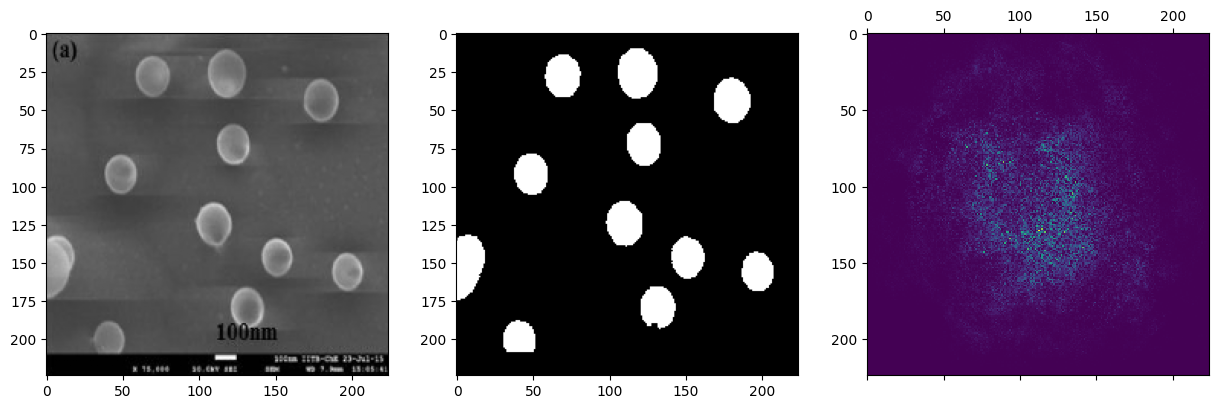

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize = (15,10))
ax[0].imshow(x_train[1])
ax[1].imshow(y_train[1], cmap = 'gray')
ax[2].matshow(preee[1])


plt.show()

### Directly use pre-trained autoencoder + output

In [2]:
ae_model = load_model('./grid-search/checkpoints/emps_models/', compile=False)
ae_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0     

In [3]:
ae_seg_model = Model(ins, decoder1_vgg16(encoder_vgg16(ins)))

In [4]:
ae_seg_model.load_weights('./grid-search/checkpoints/emps_models/')

In [5]:
ae_weights = ae_model.get_weights()[0][1]
ae_seg_weights = ae_seg_model.get_weights()[0][1]

if ae_weights.all() == ae_seg_weights.all():
    print("Both weights are identical")
else: 
    print("Something wrong, weghts are different")

Both weights are identical


In [6]:
ae_seg_train = tf.keras.models.Sequential(ae_seg_model)

In [8]:
from keras.layers import Conv2D
ae_seg_train.add(Conv2D(1, (3, 3), padding='same', activation='sigmoid'))
ae_seg_train.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 224, 224, 3)       23292355  
                                                                 
 conv2d_15 (Conv2D)          (None, 224, 224, 1)       28        
                                                                 
Total params: 23,292,383
Trainable params: 23,281,887
Non-trainable params: 10,496
_________________________________________________________________


In [9]:
import segmentation_models as sm
from keras.callbacks import TensorBoard
from datetime import datetime

logssss = './grid-search/logs/segmentation_test/ae1_' + datetime.now().strftime("%Y%m%d-%H%M%S") 
ae_seg_train.compile(optimizer='Adam', loss=sm.losses.binary_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

Segmentation Models: using `keras` framework.


In [10]:
x_train = np.load('./grid-search/dataset-emps/npy/spilt_80train_20test/x_train.npy')
y_train = np.load('./grid-search/dataset-emps/npy/spilt_80train_20test/y_train.npy')
x_test = np.load('./grid-search/dataset-emps/npy/spilt_80train_20test/x_test.npy')
y_test = np.load('./grid-search/dataset-emps/npy/spilt_80train_20test/y_test.npy')

In [11]:
ae_seg_train.fit(x_train, y_train, verbose=1, batch_size=32, validation_data=(x_test, y_test), epochs=100, shuffle=False, callbacks=[TensorBoard(log_dir=logssss)])

Epoch 1/100
11/11 [==============================] - 61s 1s/step - loss: 1.0282 - iou_score: 0.0013 - val_loss: 1.0101 - val_iou_score: 0.0014
Epoch 2/100
11/11 [==============================] - 5s 437ms/step - loss: 1.0038 - iou_score: 0.0013 - val_loss: 1.0020 - val_iou_score: 0.0014
Epoch 3/100
11/11 [==============================] - 5s 442ms/step - loss: 1.0018 - iou_score: 0.0013 - val_loss: 1.0015 - val_iou_score: 0.0014
Epoch 4/100
11/11 [==============================] - 5s 444ms/step - loss: 1.0013 - iou_score: 0.0013 - val_loss: 1.0011 - val_iou_score: 0.0014
Epoch 5/100
11/11 [==============================] - 5s 441ms/step - loss: 1.0011 - iou_score: 0.0013 - val_loss: 1.0009 - val_iou_score: 0.0014
Epoch 6/100
11/11 [==============================] - 5s 441ms/step - loss: 1.0008 - iou_score: 0.0013 - val_loss: 1.0007 - val_iou_score: 0.0014
Epoch 7/100
11/11 [==============================] - 5s 441ms/step - loss: 1.0007 - iou_score: 0.0013 - val_loss: 1.0006 - val_iou_s

The problem is still     
The problem should be in the processing of the dataset    

### Remake the dataset

In [12]:
from PIL import Image

print(Image.open('./grid-search/dataset-emps/segmaps/00655d9628.png').mode)

I


#### Mode `I` --->  (32-bit signed integer pixels)

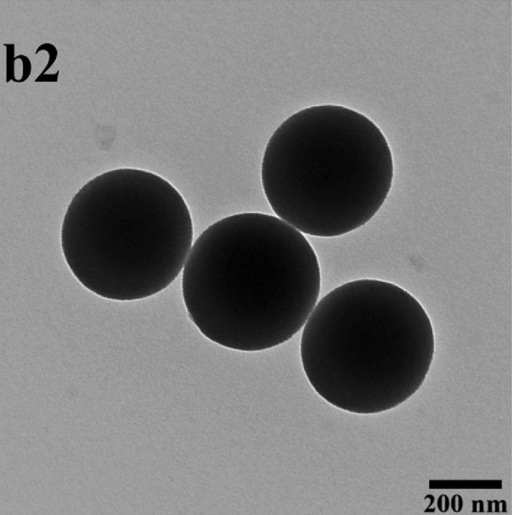

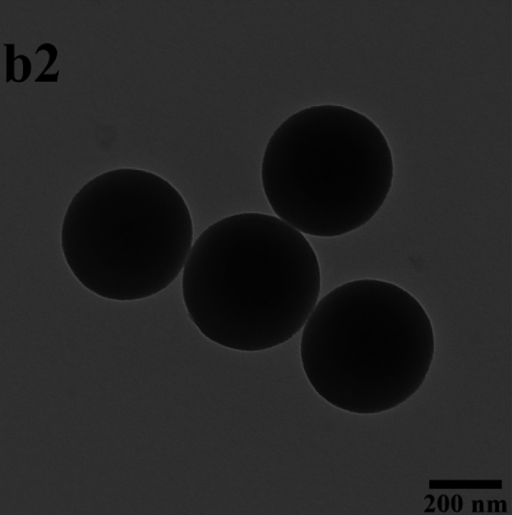

In [14]:

mask = Image.open('./grid-search/dataset-emps/segmaps/00655d9628.png')
img = Image.open('./grid-search/dataset-emps/images/00655d9628.png')
masked = Image.blend(img.convert('RGBA'),mask.convert('RGBA'), 0.7)
img.show()
masked.show()

`mask.png` is the label image    
This png is equivalent to the label label    
Classification tasks that are different from a single image    
`mask` is equivalent to classifying each pixel of this image, finding the label corresponding to this pixel, and forming an area. This area is the place to be identified    
The problem with the previous version of the dataset is that the mask as a label does not need to be normalized (`/ 255.`) This behavior    
    

Therefore, the previous model was unsuccessful, and the preliminary judgment was due to the problem of data set production.    

### 26.10  
Retry VGG16 mode

In [2]:
load_weight_model = Model(ins, encoder_vgg16(ins))

In [3]:
conn_model = tf.keras.models.Sequential(load_weight_model.layers[:-2])
conn_model.load_weights('./grid-search/checkpoints/emps_models_encoder_vgg16_weights.h5')

In [4]:
conn_model_weight = conn_model.get_weights()[0][1]
compare_weight = np.load('./grid-search/checkpoints/emps_models_encoder_weights_0_1.npy')

if conn_model_weight.all() == compare_weight.all():
    print("Both weights are identical")
else: 
    print("Something wrong, weghts are different")

Both weights are identical


In [5]:
from keras.layers import Flatten, Dense, Reshape

conn_model.add(Flatten())
conn_model.add(Dense(4096, activation='relu'))
conn_model.add(Dense(4096, activation='relu'))
conn_model.add(Dense(224*224, activation='sigmoid'))
conn_model.add(Reshape((224, 224, 1)))
conn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

In [7]:
import segmentation_models as sm
from keras.callbacks import TensorBoard
from datetime import datetime

logssss = './grid-search/logs/segmentation_test/vgg16_reshape_80train_20test_full_data_' + datetime.now().strftime("%Y%m%d-%H%M%S") 
conn_model.compile(optimizer='Adam', loss=sm.losses.binary_focal_jaccard_loss, metrics=[sm.metrics.iou_score])


In [8]:
x_train = np.load('./grid-search/dataset-emps/npy/spilt_80train_20test/x_train.npy')
y_train = np.load('./grid-search/dataset-emps/npy/spilt_80train_20test/y_train.npy')
x_test = np.load('./grid-search/dataset-emps/npy/spilt_80train_20test/x_test.npy')
y_test = np.load('./grid-search/dataset-emps/npy/spilt_80train_20test/y_test.npy')

In [9]:
conn_hs = conn_model.fit(x_train, y_train, verbose=1, batch_size=32, validation_data=(x_test, y_test), epochs=100, shuffle=False, callbacks=[TensorBoard(log_dir=logssss)])

Epoch 1/100
11/11 [==============================] - 36s 1s/step - loss: 0.8175 - iou_score: 0.2798 - val_loss: 0.8751 - val_iou_score: 0.3273
Epoch 2/100
11/11 [==============================] - 4s 377ms/step - loss: 0.7546 - iou_score: 0.3556 - val_loss: 1.1145 - val_iou_score: 0.3479
Epoch 3/100
11/11 [==============================] - 4s 381ms/step - loss: 0.7291 - iou_score: 0.3907 - val_loss: 0.7660 - val_iou_score: 0.3457
Epoch 4/100
11/11 [==============================] - 4s 376ms/step - loss: 0.6659 - iou_score: 0.4424 - val_loss: 1.1295 - val_iou_score: 0.2491
Epoch 5/100
11/11 [==============================] - 4s 377ms/step - loss: 0.6293 - iou_score: 0.4694 - val_loss: 1.0459 - val_iou_score: 0.3020
Epoch 6/100
11/11 [==============================] - 4s 376ms/step - loss: 0.5960 - iou_score: 0.5108 - val_loss: 1.0116 - val_iou_score: 0.3952
Epoch 7/100
11/11 [==============================] - 4s 376ms/step - loss: 0.5813 - iou_score: 0.5135 - val_loss: 1.0976 - val_iou_s

In [10]:
pre = conn_model.predict(x_test)

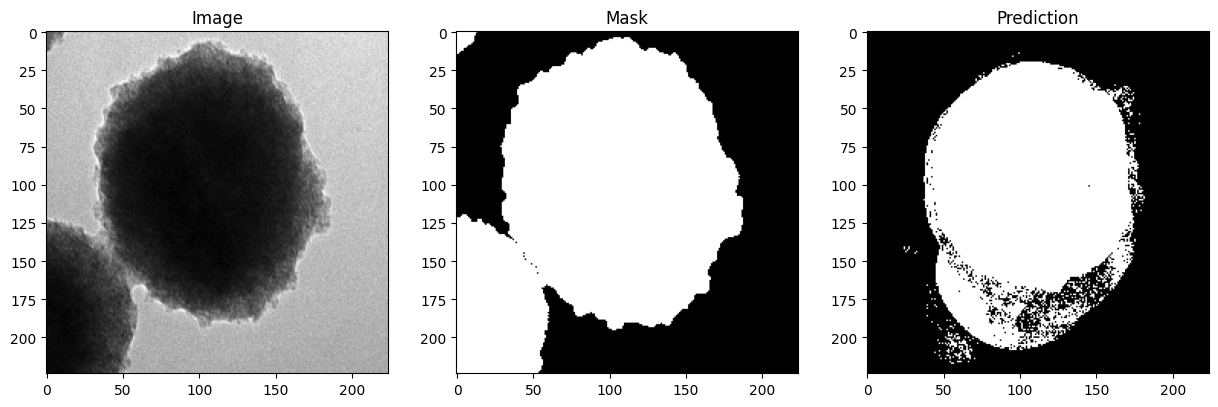

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize = (15,10))
ax[0].set_title('Image')
ax[1].set_title('Mask')
ax[2].set_title('Prediction')

ax[0].imshow(x_test[55])
ax[1].imshow(y_test[55], cmap = 'gray')
res = pre[55].round()
ax[2].imshow(np.squeeze(res), cmap = 'gray')

plt.show()

compare with random weight vgg16 model

In [2]:
tf.random.set_seed(77)

In [3]:
or_model = Model(ins, encoder_vgg16(ins))

In [4]:
or_model = tf.keras.models.Sequential(or_model.layers[:-2])

In [5]:
from keras.layers import Flatten, Dense, Reshape

or_model.add(Flatten())
or_model.add(Dense(4096, activation='relu'))
or_model.add(Dense(4096, activation='relu'))
or_model.add(Dense(224*224, activation='sigmoid'))
or_model.add(Reshape((224, 224, 1)))
or_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

In [7]:
import segmentation_models as sm
from keras.callbacks import TensorBoard
from datetime import datetime

logssss = './grid-search/logs/segmentation_test/vgg16_random_weights_reshape_80train_20test_full_data_' + datetime.now().strftime("%Y%m%d-%H%M%S") 
or_model.compile(optimizer='Adam', loss=sm.losses.binary_focal_jaccard_loss, metrics=[sm.metrics.iou_score])


In [8]:
x_train = np.load('./grid-search/dataset-emps/npy/spilt_80train_20test/x_train.npy')
y_train = np.load('./grid-search/dataset-emps/npy/spilt_80train_20test/y_train.npy')
x_test = np.load('./grid-search/dataset-emps/npy/spilt_80train_20test/x_test.npy')
y_test = np.load('./grid-search/dataset-emps/npy/spilt_80train_20test/y_test.npy')

In [9]:
or_hs = or_model.fit(x_train, y_train, verbose=1, batch_size=32, validation_data=(x_test, y_test), epochs=100, shuffle=False, callbacks=[TensorBoard(log_dir=logssss)])

Epoch 1/100
11/11 [==============================] - 16s 1s/step - loss: 0.8512 - iou_score: 0.2476 - val_loss: 2.4442 - val_iou_score: 0.0574
Epoch 2/100
11/11 [==============================] - 4s 377ms/step - loss: 0.8076 - iou_score: 0.2918 - val_loss: 2.3873 - val_iou_score: 0.0091
Epoch 3/100
11/11 [==============================] - 4s 372ms/step - loss: 0.8031 - iou_score: 0.2968 - val_loss: 2.3696 - val_iou_score: 0.0307
Epoch 4/100
11/11 [==============================] - 4s 374ms/step - loss: 0.7991 - iou_score: 0.2919 - val_loss: 2.2961 - val_iou_score: 0.1573
Epoch 5/100
11/11 [==============================] - 4s 385ms/step - loss: 0.7594 - iou_score: 0.3375 - val_loss: 2.1553 - val_iou_score: 0.0633
Epoch 6/100
11/11 [==============================] - 4s 378ms/step - loss: 0.7697 - iou_score: 0.3287 - val_loss: 1.9149 - val_iou_score: 0.1971
Epoch 7/100
11/11 [==============================] - 4s 396ms/step - loss: 0.7753 - iou_score: 0.3288 - val_loss: 1.0097 - val_iou_s